In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from plot_ensemble import ensemble, ensemble_byrcp
import significance_detection_v4 as sd

In [4]:
# supress warnings
import warnings
warnings.filterwarnings('ignore')

# Article Figures
This notebook contains figures used in the manuscript, except for the plots from the logistic regression classifier.

## Plot ensemble
Plot the entire ensemble projections (30-year moving average) for both objectives

In [5]:
def plot_ensemble():
    """Ensemble subplots for water supply reliability (SOD) and upstream
    flood volume and add scatterplot for observations"""

    df_rel = ensemble('Rel_SOD_%')
    df_flood = ensemble('Upstream_Flood_Volume_taf')
    # find historical range (max/min)
    rel_min = df_rel['1981-10-1':'2000-10-1'].min().min()
    rel_max = df_rel['1981-10-1':'2000-10-1'].max().max()
    flood_min = df_flood['1981-10-1':'2000-10-1'].min().min()
    flood_max = df_flood['1981-10-1':'2000-10-1'].max().max()

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[11, 4])

    # add scatterplot of observed values (20-year average)
    obs = pd.read_csv('obj_historical.csv', index_col=0, parse_dates=True)
    obs.loc['2020-10-1', :] = obs.loc['2000-10-1':'2020-10-1'].mean(axis=0)
    obs['datetime'] = obs.index

    axes[0].plot(obs.loc['2020-10-1', 'datetime'], obs.loc['2020-10-1', 'Rel_SOD_%'], c='red', marker='o',
                 markerfacecolor='red', markersize=5)
    axes[1].plot(obs.loc['2020-10-1', 'datetime'], obs.loc['2020-10-1', 'Upstream_Flood_Volume_taf'],
                 c='red', marker='o', markerfacecolor='red', markersize=5)

    # plot projections
    df_rel['2000-10-1':'2098-10-1'].plot(legend=False, c='lightgray', ax=axes[0], zorder=0)
    df_flood['2000-10-1':'2098-10-1'].plot(legend=False, c='lightgray', ax=axes[1], zorder=0)

    # plot mean
    df_rel.loc['2000-10-1':'2098-10-1', 'mean'].plot(c='steelblue', ax=axes[0], zorder=10)
    df_flood.loc['2000-10-1':'2098-10-1', 'mean'].plot(c='steelblue', ax=axes[1], zorder=10)

    # plot historical ranges
    axes[0].fill_between(df_rel['2000-10-1':'2098-10-1'].index, rel_min, rel_max,
                         facecolor='green', alpha=0.2, zorder=5)
    axes[1].fill_between(df_flood['2000-10-1':'2098-10-1'].index, flood_min, flood_max,
                         facecolor='green', alpha=0.2, zorder=5)

    axes[0].set_ylabel('reliability', size='x-large')
    axes[0].set_title('Water supply reliability projections, 30 yr MA', size='x-large')
    axes[1].set_ylabel('flood volume (TAF)', size='x-large')
    axes[1].set_title('Upstream flood volume projections, 30 yr MA', size='x-large')

    # create custom legend
    legend_elements = [Line2D([0], [0], color='lightgray', label='projections'),
                       Line2D([0], [0], color='steelblue', label='projections mean'),
                       Patch(facecolor='green', alpha=0.5, label='historical range'),
                       Line2D([0], [0], marker='o', color='w', label='observed value (20-yr avg)',
                              markerfacecolor='red', markersize=5)]
    axes[0].legend(handles=legend_elements)
    axes[1].legend(handles=legend_elements)

    plt.tight_layout()
    plt.savefig('significance_results/article_figures/ensemble_plot.png', dpi=300)
    plt.show()
    plt.clf()

    return

Reading data: 100%|██████████| 31/31 [00:11<00:00,  2.66it/s]


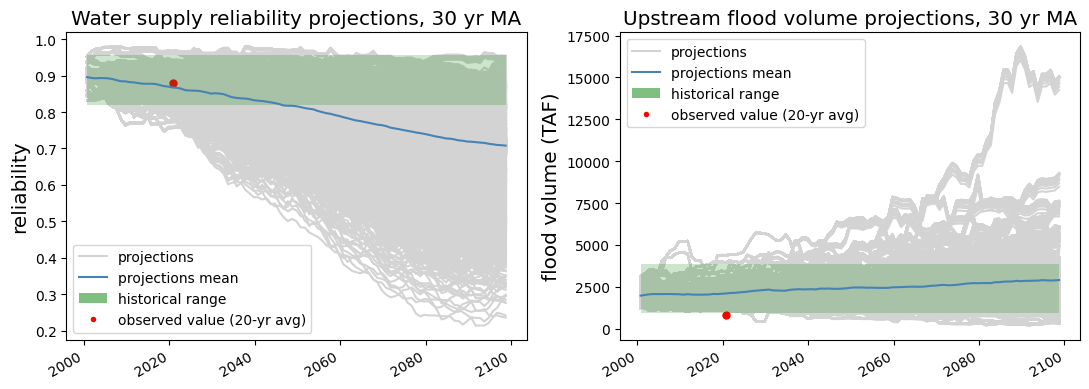

<Figure size 640x480 with 0 Axes>

In [6]:
plot_ensemble()

## Plot rcp objectives
Plot mean objectives (30-year MA) sorted by RCP and +/- standard deviation

In [11]:
def plot_rcp_objective():
    """Plot mean objective (30-year moving averages) +/- 1SD for each RCP"""

    # Get objective data, seperated by RCP
    rel_list = ensemble_byrcp('Rel_SOD_%')
    flood_list = ensemble_byrcp('Upstream_Flood_Volume_taf')

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[10, 4])

    # Plot mean water supply reliability and flooding (fill in +/-1 sd)
    rcp_list = ['rcp26', 'rcp45', 'rcp60', 'rcp85']
    color_list = ['blue', 'orange', 'green', 'red']

    for i in range(len(rcp_list)):
        mean_rel = rel_list[i].mean(axis=1)
        sd_rel = rel_list[i].std(axis=1)
        mean_flood = flood_list[i].mean(axis=1)
        sd_flood = flood_list[i].std(axis=1)

        axes[0].plot(rel_list[i].index, mean_rel, color=color_list[i], label='mean - ' + rcp_list[i])
        axes[0].fill_between(rel_list[i].index, mean_rel - sd_rel, mean_rel + sd_rel, facecolor=color_list[i], alpha=0.1)

        axes[1].plot(flood_list[i].index, mean_flood, color=color_list[i], label='mean - ' + rcp_list[i])
        axes[1].fill_between(flood_list[i].index, mean_flood - sd_flood, mean_flood + sd_flood, facecolor=color_list[i], alpha=0.1)

    # Set axis labels and title; add legend
    axes[0].set_ylabel('reliability', size='x-large')
    axes[0].set_xlabel('datetime', size='x-large')
    axes[0].set_title('Water supply reliability by RCP', size='x-large')
    axes[1].set_ylabel('flood volume (TAF)', size='x-large')
    axes[1].set_xlabel('datetime', size='x-large')
    axes[1].set_title('Upstream flood volume by RCP', size='x-large')

    axes[0].legend(loc='lower left')

    plt.tight_layout()
    plt.savefig('significance_results/article_figures/objective_byrcp_plot.png', dpi=300)
    plt.show()
    plt.clf()
    
    return

Reading data: 100%|██████████| 31/31 [00:07<00:00,  4.34it/s]


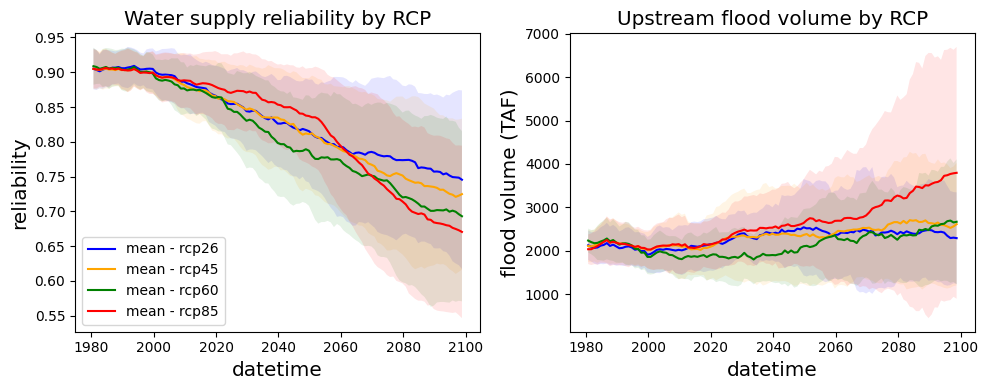

<Figure size 640x480 with 0 Axes>

In [12]:
plot_rcp_objective()

## Plot p-values
Plot the series of p-values from the sliding window MWU tests for both objectives. Distinguish between scenarios that showed a detection and those that did not (select 25 randomly from each category)

### 1. No pre-whitening

In [16]:
def pvals_filter(win_size=30, pre_whitening=False):
    """plot p-vals of scenarios. distinguish between scenarios that showed a detection and did not (25 randomly selected from each)"""

    # import pvals, delete values before year 2000 (historical)
    if pre_whitening:
        filename_rel = f'significance_results/nonparametric/Rel_SOD_%/{str(win_size)}_year_MA/less_pvals_win{str(win_size)}_pw.csv'
        filename_flood = f'significance_results/nonparametric/Upstream_Flood_Volume_taf/{str(win_size)}_year_MA/greater_pvals_win{str(win_size)}_pw.csv'
    else:
        filename_rel = f'significance_results/nonparametric/Rel_SOD_%/{str(win_size)}_year_MA/less_pvals_win{str(win_size)}.csv'
        filename_flood = f'significance_results/nonparametric/Upstream_Flood_Volume_taf/{str(win_size)}_year_MA/greater_pvals_win{str(win_size)}.csv'

    rel_p_vals = pd.read_csv(filename_rel, index_col=0, parse_dates=True).drop(['count', 'rel_count'], axis=1)
    flood_p_vals = pd.read_csv(filename_flood, index_col=0, parse_dates=True).drop(['count', 'rel_count'], axis=1)
    rel_p_vals = rel_p_vals['2000-10-1':'2098-10-1']
    flood_p_vals = flood_p_vals['2000-10-1':'2098-10-1']

    # randomly select 25 scenarios with and without detection
    if pre_whitening:
        file_nd_rel = f'significance_results/nonparametric/Rel_SOD_%/additional_materials/no_detect_scenarios_less_single_win30_pw.csv'
        file_nd_flood = f'significance_results/nonparametric/Upstream_Flood_Volume_taf/additional_materials/no_detect_scenarios_greater_single_win30_pw.csv'
    else:
        file_nd_rel = f'significance_results/nonparametric/Rel_SOD_%/additional_materials/no_detect_scenarios_less_single_win30.csv'
        file_nd_flood = f'significance_results/nonparametric/Upstream_Flood_Volume_taf/additional_materials/no_detect_scenarios_greater_single_win30.csv'

    rel_no_detect_names = pd.read_csv(file_nd_rel, index_col=0).sample(n=25, axis=0, random_state=0)['Model'].tolist()
    flood_no_detect_names = pd.read_csv(file_nd_flood, index_col=0).sample(n=25, axis=0, random_state=0)['Model'].tolist()

    rel_p_vals_no_detect = rel_p_vals[rel_no_detect_names]
    flood_p_vals_no_detect = flood_p_vals[flood_no_detect_names]

    rel_p_vals_detect = rel_p_vals.drop(rel_no_detect_names, axis=1).sample(n=25, axis=1, random_state=0)
    flood_p_vals_detect = flood_p_vals.drop(flood_no_detect_names, axis=1).sample(n=25, axis=1, random_state=0)

    # plot pvals
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[10, 5], sharey=True)
    rel_p_vals_detect.plot(ax=axes[0], c='wheat', legend=False)
    rel_p_vals_no_detect.plot(ax=axes[0], c='lightgray', legend=False)
    axes[0].set_ylabel('p-value', size='x-large')
    axes[0].set_xlabel('datetime', size='x-large')
    axes[0].set_title('Water supply reliability', size='x-large')

    flood_p_vals_detect.plot(ax=axes[1], c='wheat', legend=False)
    flood_p_vals_no_detect.plot(ax=axes[1], c='lightgray', legend=False)
    axes[1].set_title('Upstream flood volume', size='x-large')
    axes[1].set_xlabel('datetime', size='x-large')
    # plot p=0.05
    axes[0].axhline(y=0.05, color='r')
    axes[1].axhline(y=0.05, color='r')

    # create custom legend
    legend_elements = [Line2D([0], [0], color='wheat', label='scenarios with detection'),
                       Line2D([0], [0], color='lightgray', label='scenarios without detection'),
                       Line2D([0], [0], color='red', label='p=0.05'),
                       ]
    axes[1].legend(handles=legend_elements, loc='upper right')


    if pre_whitening:
        save_dir = f'significance_results/article_figures/p_vals_win{str(win_size)}_filtered_pw.png'
    else:
        save_dir = f'significance_results/article_figures/p_vals_win{str(win_size)}_filtered.png'

    plt.tight_layout()
    plt.savefig(save_dir, dpi=300)
    plt.show()
    plt.clf()

    return

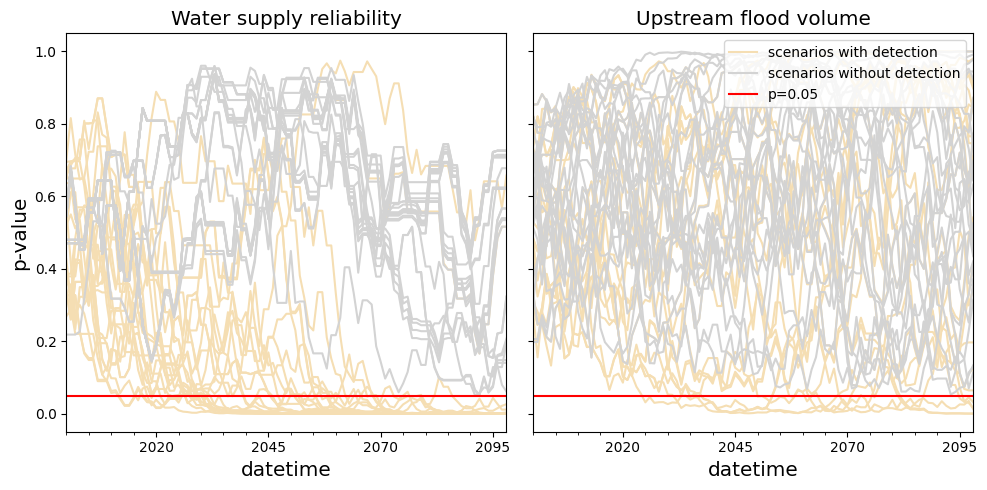

<Figure size 640x480 with 0 Axes>

In [17]:
pvals_filter()

### 2. With pre-whitening

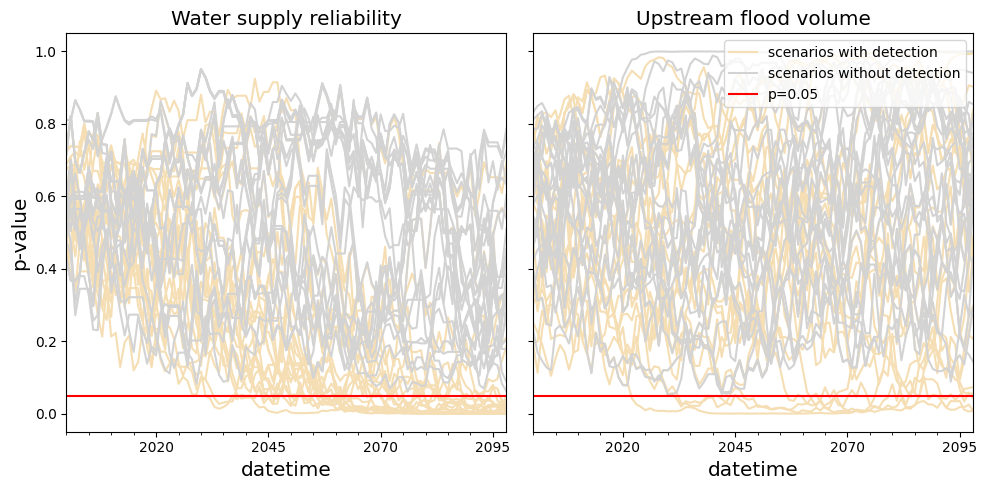

<Figure size 640x480 with 0 Axes>

In [18]:
pvals_filter(pre_whitening=True)

## Plot distribution of first detection years
### 1. No pre-whitening

In [1]:
def plot_single_total(win_size=30, pre_whitening=False):
    """Plot distribution for first detection years for water supply reliability (SOD) and upstream flood volume"""

    # Load first detection years from csv's
    if pre_whitening:
        filename_rel = f'significance_results/nonparametric/Rel_SOD_%/{str(win_size)}_year_MA/less_single_total_win{str(win_size)}_pw.csv'
        filenmae_flood = f'significance_results/nonparametric/Upstream_Flood_Volume_taf/{str(win_size)}_year_MA/greater_single_total_win{str(win_size)}_pw.csv'
    else:
        filename_rel = f'significance_results/nonparametric/Rel_SOD_%/{str(win_size)}_year_MA/less_single_total_win{str(win_size)}.csv'
        filenmae_flood = f'significance_results/nonparametric/Upstream_Flood_Volume_taf/{str(win_size)}_year_MA/greater_single_total_win{str(win_size)}.csv'

    years_rel = pd.read_csv(filename_rel, index_col=0)['Year']
    years_flood = pd.read_csv(filenmae_flood, index_col=0)['Year']

    # create subpolots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[10, 4], sharey=True)
    years_rel.plot.hist(bins=20, legend=False, ax=axes[0])
    years_flood.plot.hist(bins=20, legend=False, ax=axes[1])
    axes[0].set_xlabel('detection year')
    axes[0].set_title('First detection years for water supply reliability')
    axes[1].set_xlabel('detection year')
    axes[1].set_title('First detection years for upstream flood volume')

    ## export results
    plt.tight_layout()
    if pre_whitening:
        save_dir = 'significance_results/article_figures/first_detection_years_pw.png'
    else:
        save_dir = 'significance_results/article_figures/first_detection_years.png'

    plt.savefig(save_dir)
    plt.show()
    plt.clf()
    
    return

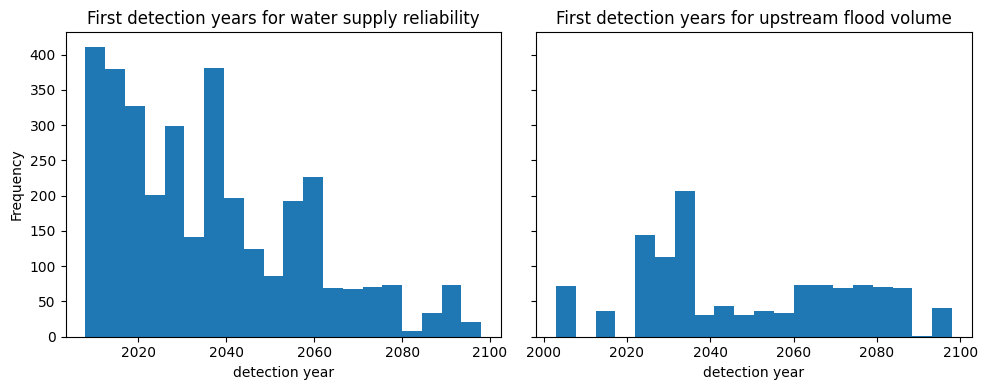

<Figure size 640x480 with 0 Axes>

In [7]:
plot_single_total()

### 2. With pre-whitening

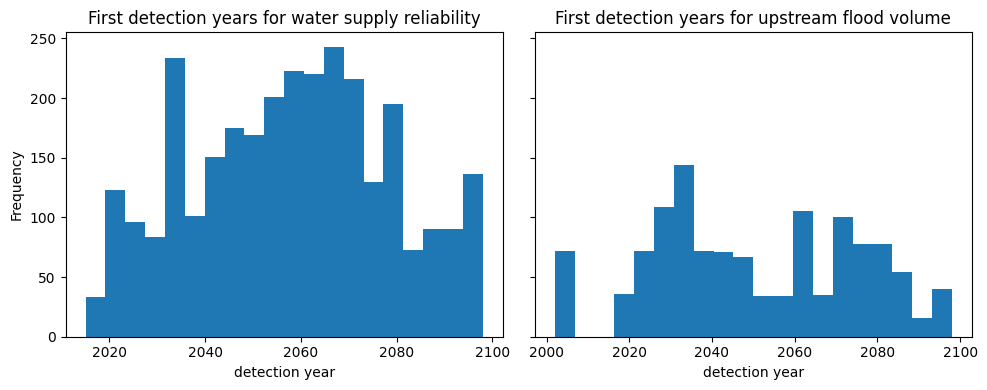

<Figure size 640x480 with 0 Axes>

In [8]:
plot_single_total(pre_whitening=True)

## Plot statistics of first detection years (sorted by rcp/gcm/lulc)

### 1. No pre-whitening

In [22]:
def plot_single_sorted(objective, win_size=30, pre_whitening=False):
    """Plot stats of first detection years (sorted by gcm/rcp/lulc)
    Params: objective = 'Rel_SOD_%' or 'Upstream_Flood_Volume_taf'
    OBJECTIVES CONSOLIDATED IN POWERPOINT"""

    # set alternative and figure title based on objective
    if objective == 'Rel_SOD_%':
        alt = 'less'
        name = 'Water supply reliability'
    else:
        alt = 'greater'
        name = 'Upstream flood volume'

    # create subplots
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=[10, 8])
    fig.suptitle(name, size='xx-large')

    # set file directories based on pre_whitening
    if pre_whitening:
        filename_gcm = f'significance_results/nonparametric/{objective}/additional_materials/{alt}_single_bygcm_win{str(win_size)}_stats_pw.csv'
        filename_rcp = f'significance_results/nonparametric/{objective}/additional_materials/{alt}_single_byrcp_win{str(win_size)}_stats_pw.csv'
        filename_lulc = f'significance_results/nonparametric/{objective}/additional_materials/{alt}_single_bylulc_win{str(win_size)}_stats_pw.csv'
    else:
        filename_gcm = f'significance_results/nonparametric/{objective}/additional_materials/{alt}_single_bygcm_win{str(win_size)}_stats.csv'
        filename_rcp = f'significance_results/nonparametric/{objective}/additional_materials/{alt}_single_byrcp_win{str(win_size)}_stats.csv'
        filename_lulc = f'significance_results/nonparametric/{objective}/additional_materials/{alt}_single_bylulc_win{str(win_size)}_stats.csv'


    # plot gcm stats
    gcm_stat = pd.read_csv(filename_gcm)
    gcm_stat = gcm_stat[['Median', 'Standard_deviation', 'Sample_size']]
    gcm_stat['Median'].plot.hist(ax=axes[0, 0])
    axes[0, 0].set_xlabel('detection year')
    axes[0, 0].set_title('Median sorted by GCM')
    gcm_stat['Standard_deviation'].plot.hist(ax=axes[0, 1])
    axes[0, 1].set_xlabel('stdev detection year')
    axes[0, 1].set_title('Stdev sorted by GCM')
    gcm_stat['Sample_size'].plot.hist(ax=axes[0, 2])
    axes[0, 2].set_xlabel('sample size')
    axes[0, 2].set_title('Sample sizes sorted by GCM')

    # plot lulc stats
    lulc_stat = pd.read_csv(filename_lulc)
    lulc_stat = lulc_stat[['Median', 'Standard_deviation', 'Sample_size']]
    lulc_stat['Median'].plot.hist(ax=axes[1, 0])
    axes[1, 0].set_xlabel('detection year')
    axes[1, 0].set_title('Median sorted by LULC')
    lulc_stat['Standard_deviation'].plot.hist(ax=axes[1, 1])
    axes[1, 1].set_xlabel('stdev detection year')
    axes[1, 1].set_title('Stdev sorted by LULC')
    lulc_stat['Sample_size'].plot.hist(ax=axes[1, 2])
    axes[1, 2].set_xlabel('sample size')
    axes[1, 2].set_title('Sample sizes sorted by LULC')

    # plot rcp stats
    rcp_stat = pd.read_csv(filename_rcp)
    axes[2, 0].bar(rcp_stat['byrcp'], rcp_stat['Median'], width=0.4)
    axes[2, 0].set_ylim(bottom=2000, top=2075)
    axes[2, 0].set_ylabel('Detection year')
    axes[2, 0].set_title('Median sorted by RCP')
    axes[2, 1].bar(rcp_stat['byrcp'], rcp_stat['Standard_deviation'], width=0.4)
    axes[2, 1].set_ylabel('Stdev detection year')
    axes[2, 1].set_title('Stdev sorted by RCP')
    axes[2, 2].bar(rcp_stat['byrcp'], rcp_stat['Sample_size'], width=0.4)
    axes[2, 2].set_ylabel('Sample size')
    axes[2, 2].set_title('Sample sizes sorted by RCP')

    if pre_whitening:
        save_dir = f'significance_results/article_figures/first_detection_stats_{objective}_pw.png'
    else:
        save_dir = f'significance_results/article_figures/first_detection_stats_{objective}.png'
    plt.tight_layout()
    plt.savefig(save_dir, dpi=300)
    plt.show()
    plt.clf()

    return

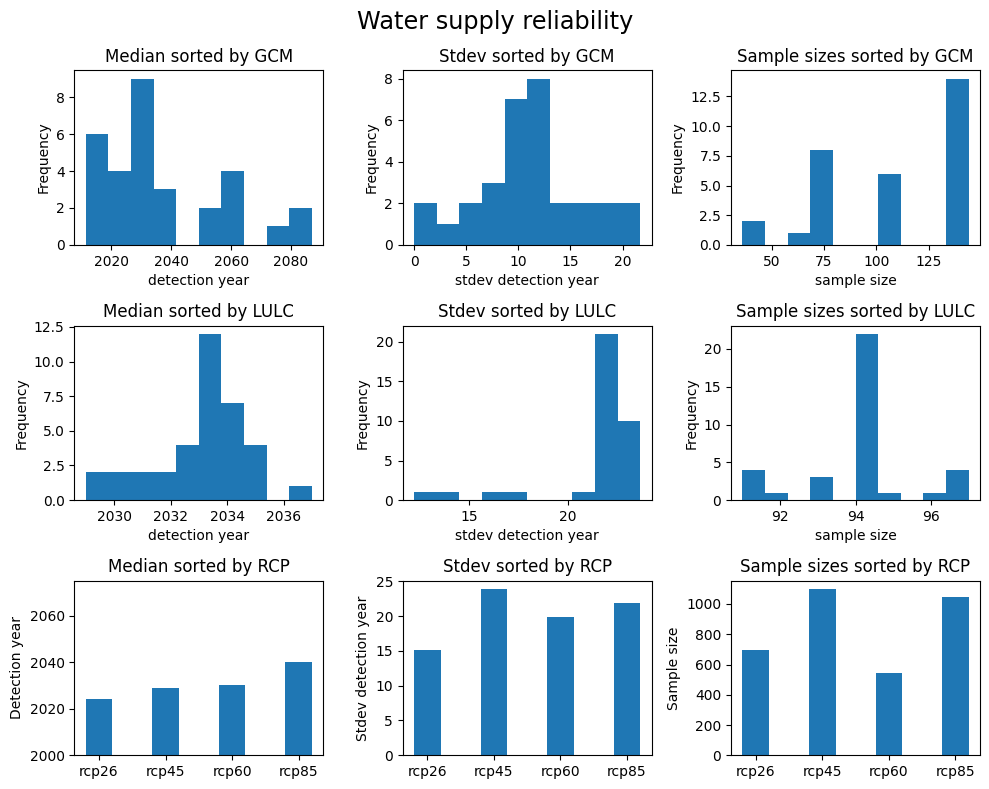

<Figure size 640x480 with 0 Axes>

In [23]:
plot_single_sorted('Rel_SOD_%')

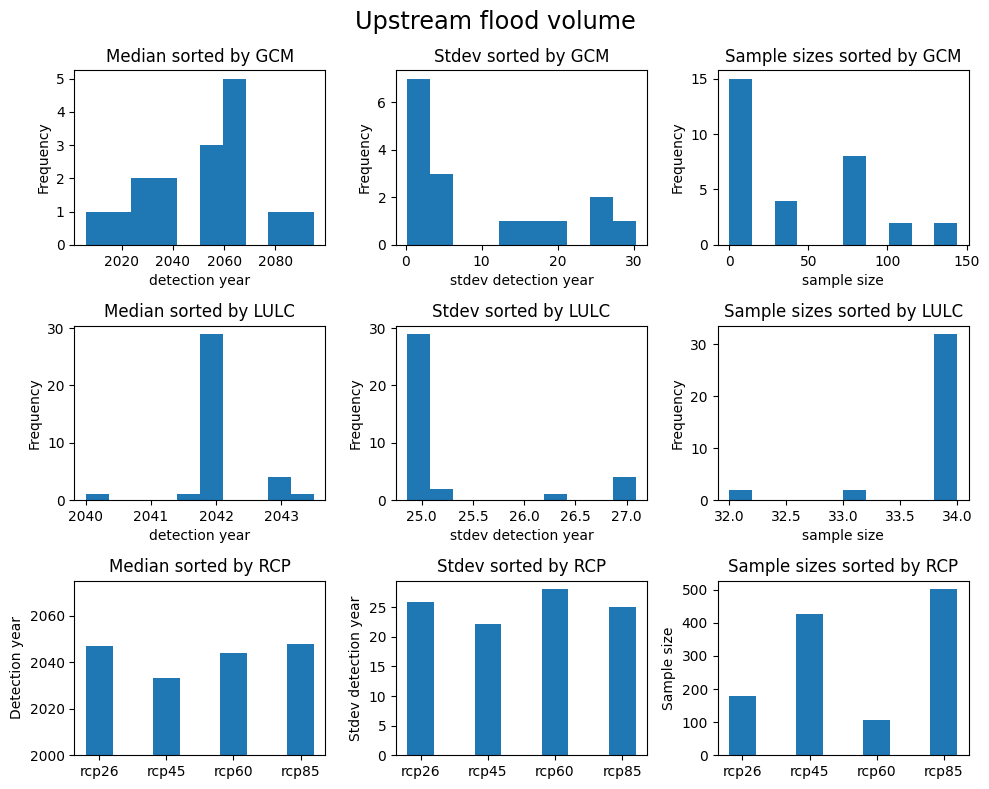

<Figure size 640x480 with 0 Axes>

In [24]:
plot_single_sorted('Upstream_Flood_Volume_taf')

### 2. With pre-whitening

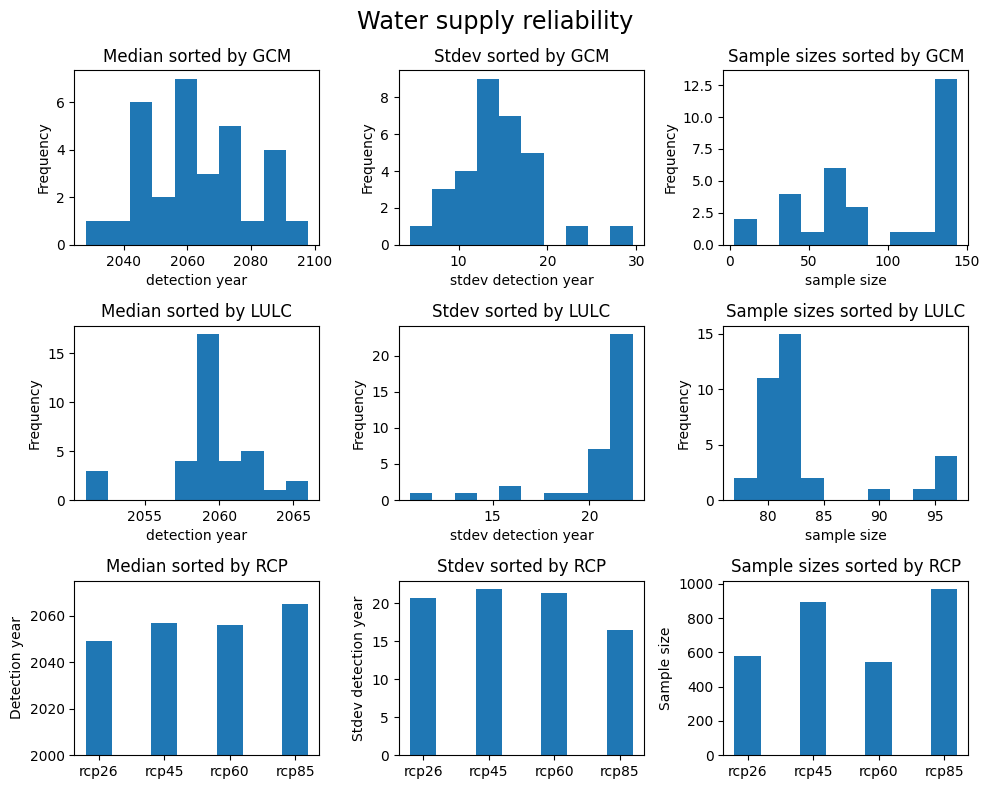

<Figure size 640x480 with 0 Axes>

In [25]:
plot_single_sorted('Rel_SOD_%', pre_whitening=True)

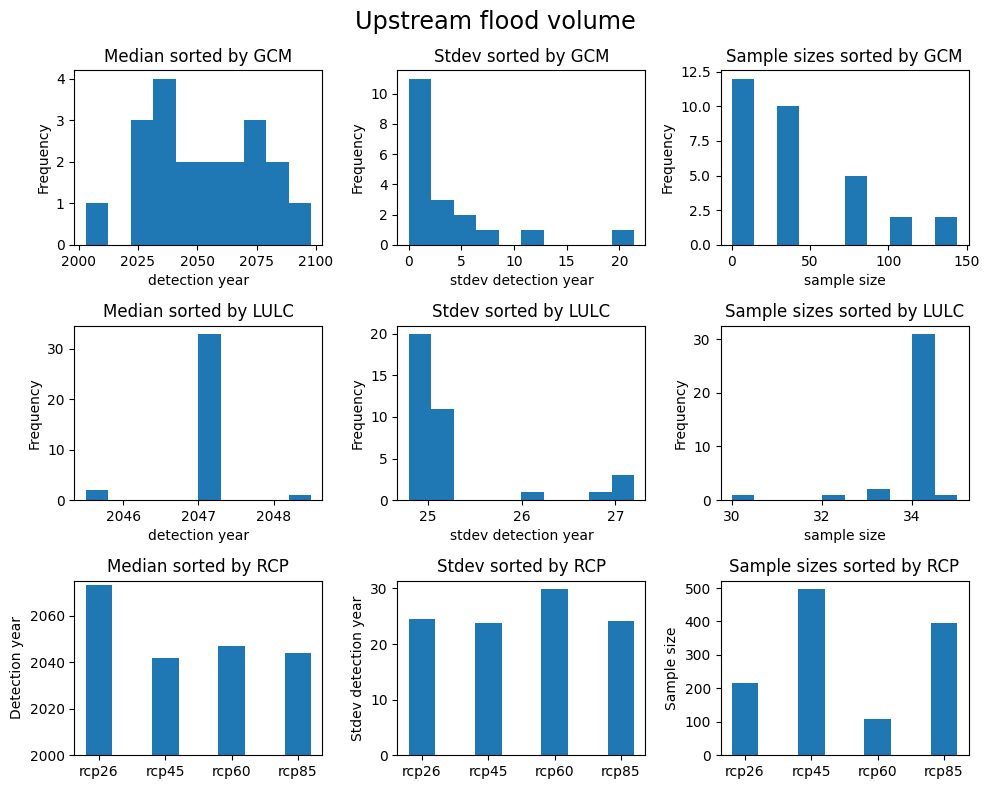

<Figure size 640x480 with 0 Axes>

In [26]:
plot_single_sorted('Upstream_Flood_Volume_taf', pre_whitening=True)

## Plot distribution of first detection years, sorted by RCP

### 1. No pre-whitening

In [29]:
def plot_single_rcp_subplots(objective, win_size=30, pre_whitening=False):
    """Plots subplots of distributions of first detections years sorted by RCP
    OBJECTIVES CONSOLIDATED IN POWERPOINT"""

    # set alternative and figure title based on objective
    if objective == 'Rel_SOD_%':
        alt = 'less'
        name = 'Water supply reliability'
    else:
        alt = 'greater'
        name = 'Upstream flood volume'

    # read data from csv
    if pre_whitening:
        filename = f'significance_results/nonparametric/{objective}/{str(win_size)}_year_MA/{alt}_single_byrcp_win{str(win_size)}_pw.csv'
    else:
        filename = f'significance_results/nonparametric/{objective}/{str(win_size)}_year_MA/{alt}_single_byrcp_win{str(win_size)}.csv'
    df = pd.read_csv(filename, index_col=0)

    # plot histograms grouped by rcp
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(5, 5))
    df.hist(bins=10, grid=False, ax=axes)
    for ax in axes.flatten():
        ax.set_xlabel('detection year', size='large')
    fig.suptitle(name, size='xx-large')

    plt.tight_layout()
    if pre_whitening:
        save_dir = f'significance_results/article_figures/first_detection_by_rcp_{objective}_pw.png'
    else:
        save_dir = f'significance_results/article_figures/first_detection_by_rcp_{objective}.png'

    plt.savefig(save_dir, dpi=300)
    plt.show()
    plt.clf()
    return

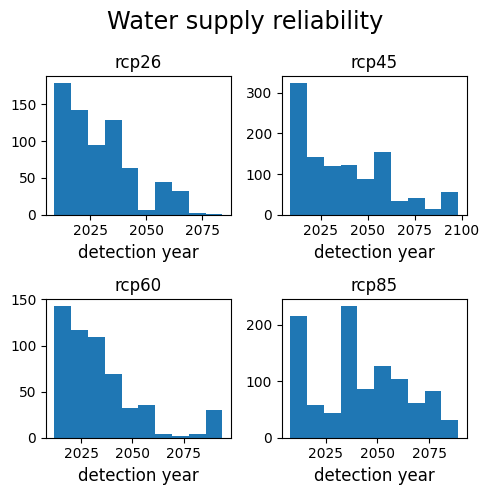

<Figure size 640x480 with 0 Axes>

In [30]:
plot_single_rcp_subplots('Rel_SOD_%')

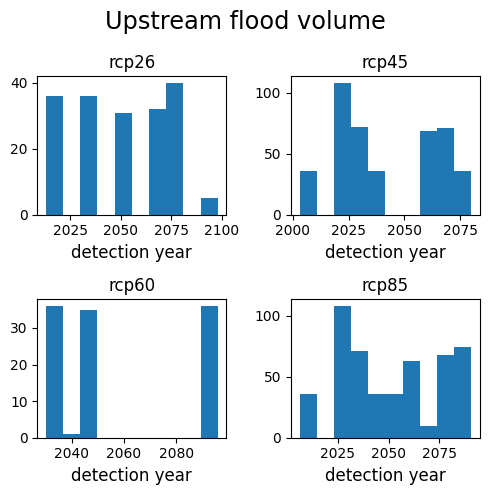

<Figure size 640x480 with 0 Axes>

In [31]:
plot_single_rcp_subplots('Upstream_Flood_Volume_taf')

### 2. With pre-whitening

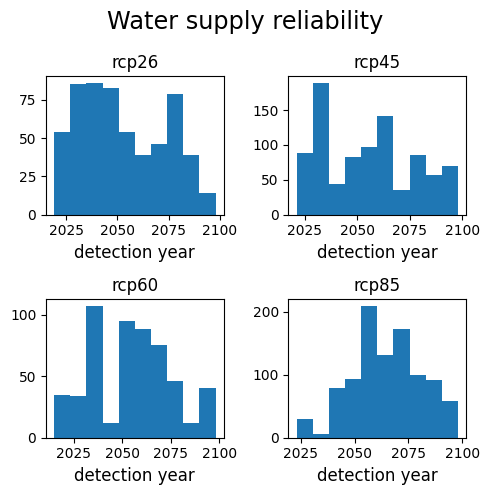

<Figure size 640x480 with 0 Axes>

In [32]:
plot_single_rcp_subplots('Rel_SOD_%', pre_whitening=True)

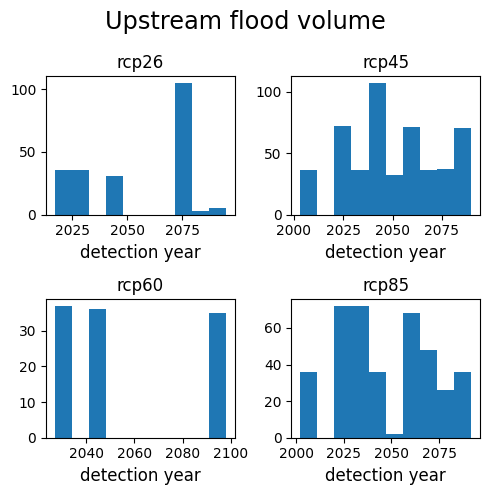

<Figure size 640x480 with 0 Axes>

In [34]:
plot_single_rcp_subplots('Upstream_Flood_Volume_taf', pre_whitening=True)

## Plot overall detection rates

### 1. No pre-whitening

In [9]:
def plot_multi_total(win_size=30, pre_whitening=False):
    """Plot detection rates for water supply reliability (SOD) and upstream flood volume"""

    # Load p-val data (rel counts is included as a column)
    if pre_whitening:
        filename_rel = f'significance_results/nonparametric/Rel_SOD_%/{str(win_size)}_year_MA/less_pvals_win30_pw.csv'
        filename_flood = f'significance_results/nonparametric/Upstream_Flood_Volume_taf/{str(win_size)}_year_MA/greater_pvals_win30_pw.csv'
    else:
        filename_rel = f'significance_results/nonparametric/Rel_SOD_%/{str(win_size)}_year_MA/less_pvals_win30.csv'
        filename_flood = f'significance_results/nonparametric/Upstream_Flood_Volume_taf/{str(win_size)}_year_MA/greater_pvals_win30.csv'

    agg_all_rel = pd.read_csv(filename_rel, index_col=0, parse_dates=True)
    agg_all_flood = pd.read_csv(filename_flood, index_col=0, parse_dates=True)

    # Plot total relative counts
    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=[10, 4.5])
    agg_all_rel.loc['2000-10-1':'2098-10-1', 'rel_count'].plot(ax=axes[0])
    agg_all_flood.loc['2000-10-1':'2098-10-1', 'rel_count'].plot(ax=axes[1])

    axes[0].set_ylabel('detection rate', size='x-large')
    axes[0].set_title('Water supply reliability', size='xx-large')
    axes[0].set_xlabel('datetime', size='xx-large')
    axes[1].set_ylabel('detection rate', size='x-large')
    axes[1].set_title('Upstream flood volume', size='xx-large')
    axes[1].set_xlabel('datetime', size='xx-large')
    fig.suptitle('Fraction of scenarios with detection', size='xx-large')

    if pre_whitening:
        save_dir = 'significance_results/article_figures/detection_rate_pw.png'
    else:
        save_dir = 'significance_results/article_figures/detection_rate.png'

    plt.tight_layout()
    plt.savefig(save_dir, dpi=300)
    plt.show()
    plt.clf()

    return

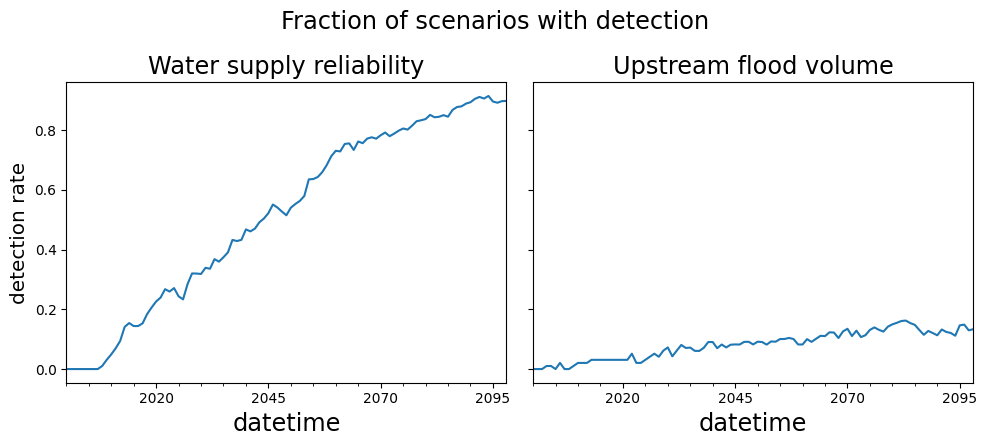

<Figure size 640x480 with 0 Axes>

In [10]:
plot_multi_total()

### 2. With pre-whitening

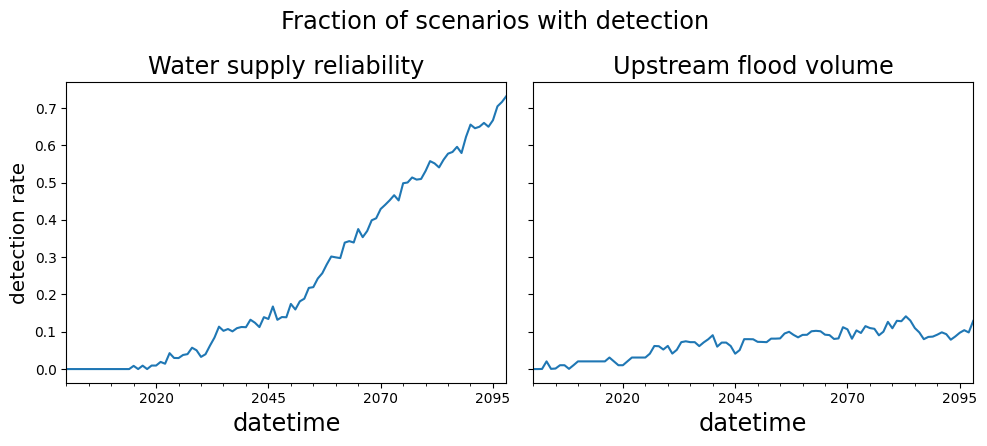

<Figure size 640x480 with 0 Axes>

In [11]:
plot_multi_total(pre_whitening=True)

## Plot detection rates sorted by gcm/rcp/lulc in end of simulation (2098)

### 1. No pre_whitening

In [35]:
def plot_multi_sorted(win_size=30, pre_whitening=False):
    """Create histograms for detection rates by gcm/rcp/lulc at the end of simulation (2098)"""

    # get file directories based on pre_whitening
    if pre_whitening:
        file_rel_gcm = f'significance_results/nonparametric/Rel_SOD_%/{str(win_size)}_year_MA/less_multi_bygcm_win{str(win_size)}_pw.csv'
        file_rel_rcp = f'significance_results/nonparametric/Rel_SOD_%/{str(win_size)}_year_MA/less_multi_byrcp_win{str(win_size)}_pw.csv'
        file_rel_lulc = f'significance_results/nonparametric/Rel_SOD_%/{str(win_size)}_year_MA/less_multi_bylulc_win{str(win_size)}_pw.csv'

        file_flood_gcm = f'significance_results/nonparametric/Upstream_Flood_Volume_taf/{str(win_size)}_year_MA/greater_multi_bygcm_win{str(win_size)}_pw.csv'
        file_flood_rcp = f'significance_results/nonparametric/Upstream_Flood_Volume_taf/{str(win_size)}_year_MA/greater_multi_byrcp_win{str(win_size)}_pw.csv'
        file_flood_lulc = f'significance_results/nonparametric/Upstream_Flood_Volume_taf/{str(win_size)}_year_MA/greater_multi_bylulc_win{str(win_size)}_pw.csv'

    else:
        file_rel_gcm = f'significance_results/nonparametric/Rel_SOD_%/{str(win_size)}_year_MA/less_multi_bygcm_win{str(win_size)}.csv'
        file_rel_rcp = f'significance_results/nonparametric/Rel_SOD_%/{str(win_size)}_year_MA/less_multi_byrcp_win{str(win_size)}.csv'
        file_rel_lulc = f'significance_results/nonparametric/Rel_SOD_%/{str(win_size)}_year_MA/less_multi_bylulc_win{str(win_size)}.csv'

        file_flood_gcm = f'significance_results/nonparametric/Upstream_Flood_Volume_taf/{str(win_size)}_year_MA/greater_multi_bygcm_win{str(win_size)}.csv'
        file_flood_rcp = f'significance_results/nonparametric/Upstream_Flood_Volume_taf/{str(win_size)}_year_MA/greater_multi_byrcp_win{str(win_size)}.csv'
        file_flood_lulc = f'significance_results/nonparametric/Upstream_Flood_Volume_taf/{str(win_size)}_year_MA/greater_multi_bylulc_win{str(win_size)}.csv'

    # load detection rates for water supply reliability sorted by gcm/rcp/lulc
    df_gcm_rel = pd.read_csv(file_rel_gcm, index_col=0, parse_dates=True)
    df_rcp_rel = pd.read_csv(file_rel_rcp, index_col=0, parse_dates=True)
    df_lulc_rel = pd.read_csv(file_rel_lulc, index_col=0, parse_dates=True)

    # load detection rates for flood volume sorted by gcm/rcp/lulc
    df_gcm_flood = pd.read_csv(file_flood_gcm, index_col=0, parse_dates=True)
    df_rcp_flood = pd.read_csv(file_flood_rcp, index_col=0, parse_dates=True)
    df_lulc_flood = pd.read_csv(file_flood_lulc, index_col=0, parse_dates=True)

    # create subplots
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=[10, 6])
    fig.suptitle('Distribution of detection rates in 2098 by GCM/RCP/LULC')

    df_gcm_rel.loc['2098-10-01', :].plot.hist(bins=10, ax=axes[0, 0])
    axes[0, 0].set_title('Water supply reliability by GCM')
    axes[0, 0].set_xlabel('detection rate')

    df_lulc_rel.loc['2098-10-01', :].plot.hist(bins=10, ax=axes[0, 1])
    axes[0, 1].set_title('Water supply reliability by LULC')
    axes[0, 1].set_xlabel('detection rate')

    # df_rcp_rel.loc['2098-10-01', :].plot.hist(bins=10, ax=axes[0, 2])
    axes[0, 2].bar(['rcp26', 'rcp45', 'rcp60', 'rcp85'], df_rcp_rel.loc['2098-10-01', :], width=0.4)
    axes[0, 2].set_title('Water supply reliability by RCP')
    axes[0, 2].set_ylabel('detection rate')
    axes[0, 2].set_ylim(top=1)

    df_gcm_flood.loc['2098-10-01', :].plot.hist(bins=10, ax=axes[1, 0])
    axes[1, 0].set_title('Upstream flood volume by GCM')
    axes[1, 0].set_xlabel('detection rate')

    df_lulc_flood.loc['2098-10-01', :].plot.hist(bins=10, ax=axes[1, 1])
    axes[1, 1].set_title('Upstream flood volume by LULC')
    axes[1, 1].set_xlabel('detection rate')
    # axes[1, 1].set_xlim(left=0, right=1)

    # df_rcp_flood.loc['2098-10-01', :].plot.hist(bins=10, ax=axes[1, 2])
    axes[1, 2].bar(['rcp26', 'rcp45', 'rcp60', 'rcp85'], df_rcp_flood.loc['2098-10-01', :], width=0.4)
    axes[1, 2].set_title('Upstream flood volume by RCP')
    axes[1, 2].set_ylabel('detection rate')
    axes[1, 2].set_ylim(top=1)

    if pre_whitening:
        save_dir = 'significance_results/article_figures/detection_rate_sorted_pw.png'
    else:
        save_dir = 'significance_results/article_figures/detection_rate_sorted.png'
    plt.tight_layout()
    plt.savefig(save_dir, dpi=300)
    plt.show()
    plt.clf()

    return

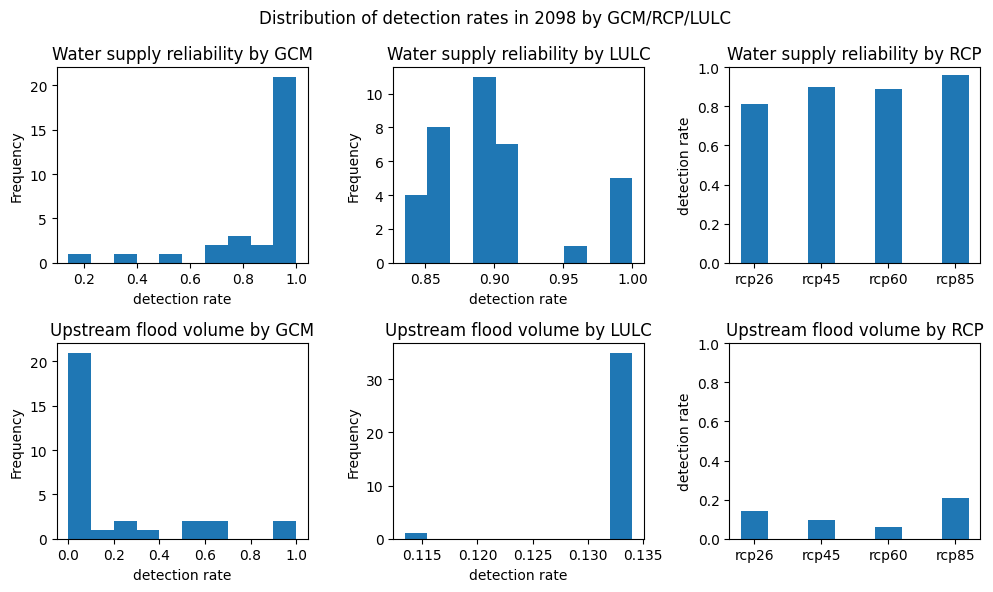

<Figure size 640x480 with 0 Axes>

In [36]:
plot_multi_sorted()

### 2. With pre_whitening

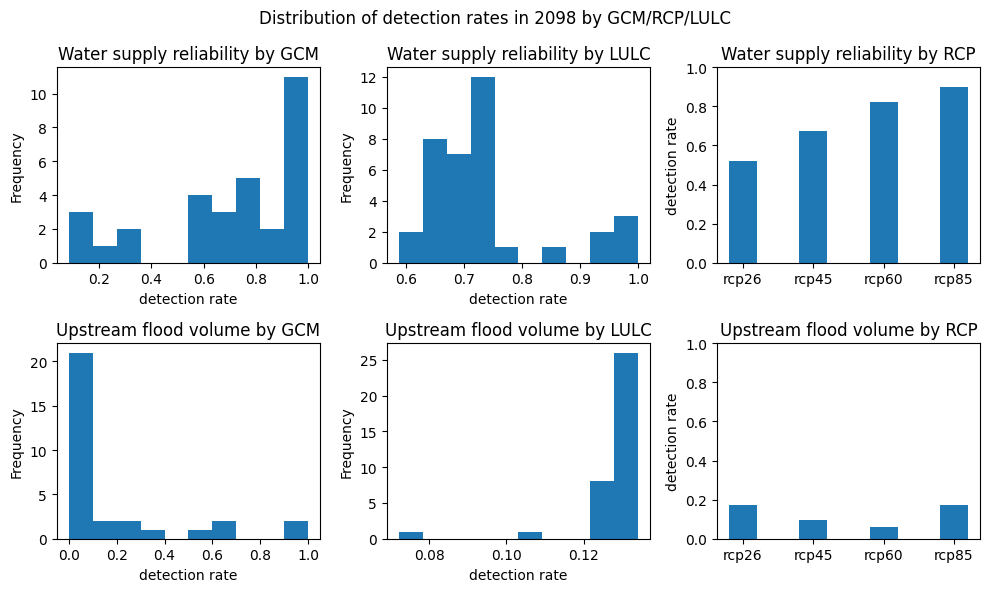

<Figure size 640x480 with 0 Axes>

In [37]:
plot_multi_sorted(pre_whitening=True)

## Plot detection year vs end of simulation severity

In [39]:
def detect_vs_end_obj(objective, win_size=30, pre_whitening=False):
    """Single scenario: Plot first detection year against objective value (moving average) at END OF PROJECTION (2098)
    Includes distribution of no-detect scenarios as boxplot
    OBJECTIVES CONSOLIDATED IN POWERPOINT"""

    # set alternative and figure title based on objective
    if objective == 'Rel_SOD_%':
        alt = 'less'
        name = 'water supply reliability'
    else:
        alt = 'greater'
        name = 'upstream flood volume'

    # initiate empty lists to store data WITH DETECTION
    model_list = []
    detection_year = []
    objective_values = []

    # initiate empty lists to store data from NO DETECT scenarios
    model_list_nd = []
    objective_values_nd = []

    # load csv with all first detection years
    if pre_whitening:
        filename = f'significance_results/nonparametric/{objective}/{str(win_size)}_year_MA/{alt}_single_total_win{str(win_size)}_pw.csv'
    else:
        filename = f'significance_results/nonparametric/{objective}/{str(win_size)}_year_MA/{alt}_single_total_win{str(win_size)}.csv'

    df_years = pd.read_csv(filename, index_col=0)
    # iterate over models, row stores model name and first detection year
    for row in tqdm(df_years.itertuples(index=False), desc='Building df...'):
        # handle no detect models
        if np.isnan(row[1]):
            model_list_nd.append(row[0])

            # extract gcm/rcp/lulc from model name
            gcm = row[0].split('_')[0]
            rcp = row[0].split('_')[1]
            try:
                lulc = row[0].split('_')[2] + '_' + row[0].split('_')[3]
            except IndexError:
                lulc = row[0].split('_')[2]

            # read model objective value at 2098 (trailing average)
            scenario = gcm + '_' + rcp + '_r1i1p1'
            df_obj = pd.read_csv('data/obj_' + scenario + '_' + lulc + '.csv.zip', index_col=0, parse_dates=True)
            objective_values_nd.append(df_obj.loc[str(2098 - win_size + 1) + '-10-1':'2098-10-1', objective].mean())

        else:
            model_list.append(row[0])
            detection_year.append(row[1])

            # extract gcm/rcp/lulc from model name
            gcm = row[0].split('_')[0]
            rcp = row[0].split('_')[1]
            try:
                lulc = row[0].split('_')[2] + '_' + row[0].split('_')[3]
            except IndexError:
                lulc = row[0].split('_')[2]

            # read model objective value at 2098 (trailing average)
            scenario = gcm + '_' + rcp + '_r1i1p1'
            df_obj = pd.read_csv('data/obj_' + scenario + '_' + lulc + '.csv.zip', index_col=0, parse_dates=True)
            objective_values.append(df_obj.loc[str(2098 - win_size + 1) + '-10-1':'2098-10-1', objective].mean())

    # build data frames and export plot ('ND', "no detection", stores severity of no detect scenarios)
    data = {'Model': model_list, 'Detection_year': detection_year, objective: objective_values}
    data_nd = {'Model': model_list_nd, 'ND': objective_values_nd}
    output_df = pd.DataFrame(data)
    output_nd_df = pd.DataFrame(data_nd)

    # create scatter (right) and boxplot of values for scenarios with no detection (left)
    fig = plt.figure()
    gs = fig.add_gridspec(1, 2, wspace=0, width_ratios=[10, 1])
    axs = gs.subplots(sharey=True)

    output_df.plot.scatter(x='Detection_year', y=objective, ax=axs[0])
    boxplot = output_nd_df.boxplot(column='ND', grid=False, return_type='dict', ax=axs[1], widths=0.7)

    # customize plots
    # see boxplot customization options:
    # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html#matplotlib.pyplot.boxplot
    axs[1].spines['left'].set_visible(False)
    axs[1].tick_params(left=False)
    axs[0].spines['right'].set_visible(False)
    axs[0].set_xlabel('detection year', size=15)
    # axs[0].set_title(name, size='xx-large')
    axs[0].set_ylabel(name + ' (end of century)', size=15)
    boxplot['fliers'][0].set(markersize=4, mec='black')
    boxplot['boxes'][0].set(linewidth=1, color='black')
    boxplot['medians'][0].set(linewidth=1, color='black')
    for cap in boxplot['caps']:
        cap.set(linewidth=1, color='black')
    for whisker in boxplot['whiskers']:
        whisker.set(linewidth=1, color='black')

    plt.tight_layout()
    if pre_whitening:
        save_dir = f'significance_results/article_figures/{objective}_detect_2098obj_{alt}_single_win{str(win_size)}_pw.png'
    else:
        save_dir = f'significance_results/article_figures/{objective}_detect_2098obj_{alt}_single_win{str(win_size)}.png'
    plt.savefig(save_dir, dpi=300)
    plt.show()
    plt.clf()

    return output_df

### 1. No pre-whitening

Building df...: 3492it [00:13, 261.92it/s]


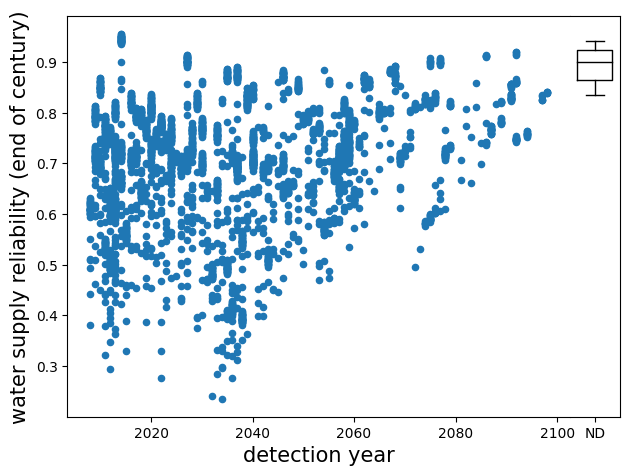

,Model,Detection_year,Rel_SOD_%
0,access1-0_rcp45_FORE-SCE-A1B,2011.0,0.612601
1,access1-0_rcp45_FORE-SCE-A2,2011.0,0.637775
2,access1-0_rcp45_FORE-SCE-B1,2011.0,0.681006
3,access1-0_rcp45_GCAM-26,2011.0,0.468376
4,access1-0_rcp45_GCAM-45,2011.0,0.547491
...,...,...,...
3377,noresm1-m_rcp85_LUCAS-BAU_Med-0006,2046.0,0.694779
3378,noresm1-m_rcp85_LUCAS-BAU_Med-0007,2046.0,0.696696
3379,noresm1-m_rcp85_LUCAS-BAU_Med-0008,2046.0,0.693566
3380,noresm1-m_rcp85_LUCAS-BAU_Med-0009,2046.0,0.688725


<Figure size 640x480 with 0 Axes>

In [40]:
detect_vs_end_obj('Rel_SOD_%')

Building df...: 3492it [00:09, 352.52it/s]


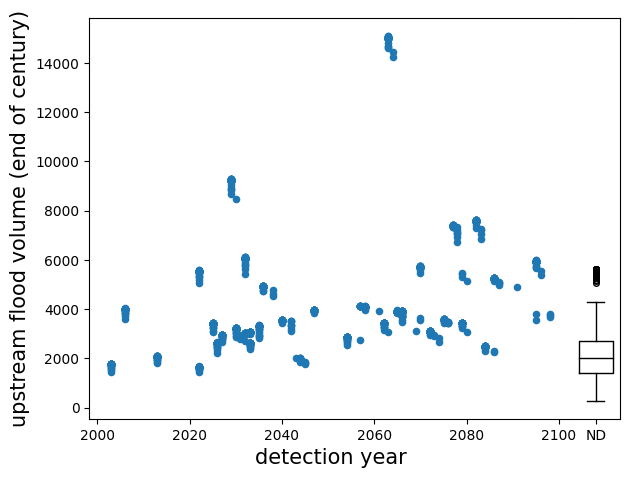

,Model,Detection_year,Upstream_Flood_Volume_taf
0,bcc-csm1-1-m_rcp45_FORE-SCE-A1B,2022.0,1565.079601
1,bcc-csm1-1-m_rcp45_FORE-SCE-A2,2022.0,1580.537770
2,bcc-csm1-1-m_rcp45_FORE-SCE-B1,2022.0,1609.132136
3,bcc-csm1-1-m_rcp45_GCAM-26,2022.0,1435.237100
4,bcc-csm1-1-m_rcp45_GCAM-45,2022.0,1513.225940
...,...,...,...
1213,mri-cgcm3_rcp85_LUCAS-BAU_Med-0006,2054.0,2849.607076
1214,mri-cgcm3_rcp85_LUCAS-BAU_Med-0007,2054.0,2851.799932
1215,mri-cgcm3_rcp85_LUCAS-BAU_Med-0008,2054.0,2848.316877
1216,mri-cgcm3_rcp85_LUCAS-BAU_Med-0009,2054.0,2843.952204


<Figure size 640x480 with 0 Axes>

In [41]:
detect_vs_end_obj('Upstream_Flood_Volume_taf')

### 2. With pre-whitening

Building df...: 3492it [00:17, 203.48it/s]


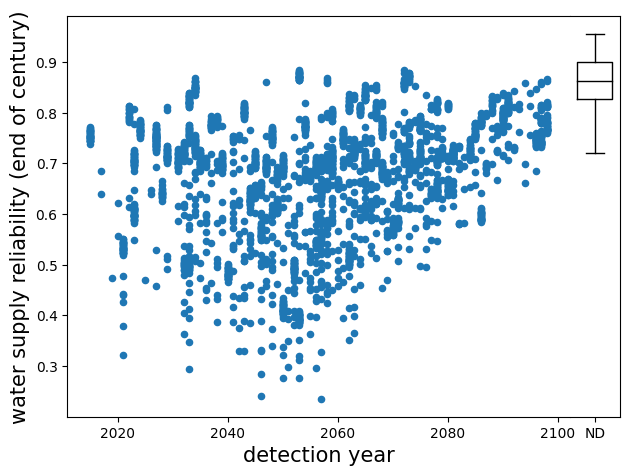

,Model,Detection_year,Rel_SOD_%
0,access1-0_rcp45_FORE-SCE-A1B,2071.0,0.612601
1,access1-0_rcp45_FORE-SCE-A2,2081.0,0.637775
2,access1-0_rcp45_FORE-SCE-B1,2087.0,0.681006
3,access1-0_rcp45_GCAM-26,2057.0,0.468376
4,access1-0_rcp45_GCAM-45,2036.0,0.547491
...,...,...,...
2978,noresm1-m_rcp85_LUCAS-BAU_Med-0006,2057.0,0.694779
2979,noresm1-m_rcp85_LUCAS-BAU_Med-0007,2057.0,0.696696
2980,noresm1-m_rcp85_LUCAS-BAU_Med-0008,2057.0,0.693566
2981,noresm1-m_rcp85_LUCAS-BAU_Med-0009,2057.0,0.688725


<Figure size 640x480 with 0 Axes>

In [42]:
detect_vs_end_obj('Rel_SOD_%', pre_whitening=True)

Building df...: 3492it [00:10, 344.66it/s]


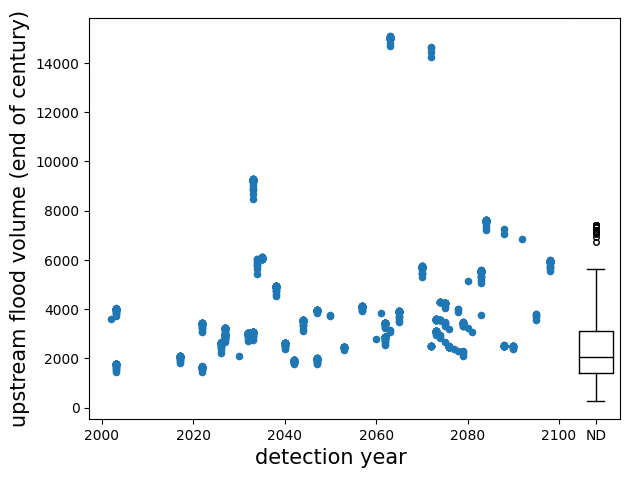

,Model,Detection_year,Upstream_Flood_Volume_taf
0,bcc-csm1-1-m_rcp45_FORE-SCE-A1B,2022.0,1565.079601
1,bcc-csm1-1-m_rcp45_FORE-SCE-A2,2022.0,1580.537770
2,bcc-csm1-1-m_rcp45_FORE-SCE-B1,2022.0,1609.132136
3,bcc-csm1-1-m_rcp45_GCAM-26,2022.0,1435.237100
4,bcc-csm1-1-m_rcp45_GCAM-45,2022.0,1513.225940
...,...,...,...
1212,mri-cgcm3_rcp85_LUCAS-BAU_Med-0006,2062.0,2849.607076
1213,mri-cgcm3_rcp85_LUCAS-BAU_Med-0007,2062.0,2851.799932
1214,mri-cgcm3_rcp85_LUCAS-BAU_Med-0008,2062.0,2848.316877
1215,mri-cgcm3_rcp85_LUCAS-BAU_Med-0009,2062.0,2843.952204


<Figure size 640x480 with 0 Axes>

In [43]:
detect_vs_end_obj('Upstream_Flood_Volume_taf', pre_whitening=True)